In [12]:
import os
import json
import base64
import time
import pickle
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, asdict
from enum import Enum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

print("Imports complete")

Imports complete


In [13]:
#Define Data Structures
class TaskType(Enum):
    """Types of visual reasoning tasks"""
    SPATIAL_LEFT_RIGHT = "spatial_left_right"
    SPATIAL_ABOVE_BELOW = "spatial_above_below"
    SPATIAL_PROXIMITY = "spatial_proximity"
    OBJECT_COUNTING = "object_counting"

@dataclass
class VisualReasoningTask:
    """Single visual reasoning task"""
    task_id: str
    task_type: str
    image_path: str
    prompt: str
    ground_truth: Any
    metadata: Dict = None

    def to_dict(self):
        return asdict(self)

@dataclass
class EvaluationResult:
    """Result of a single evaluation"""
    task_id: str
    predicted: Any
    ground_truth: Any
    correct: bool
    response_text: str
    tokens_used: int = 0
    error: str = None

    def to_dict(self):
        return asdict(self)

print("Data structures defined")

Data structures defined


In [14]:
# Dataset Generator
class DatasetGenerator:
    """Generate synthetic datasets for visual reasoning tasks"""

    def __init__(self, output_dir: Path):
        self.output_dir = output_dir
        self.output_dir.mkdir(exist_ok=True, parents=True)

    def create_spatial_dataset(self, num_samples: int = 40) -> List[VisualReasoningTask]:
        """Create spatial reasoning dataset"""
        tasks = []

        # Generate different types of spatial tasks
        tasks_per_type = num_samples // 3

        # Left/Right tasks
        for i in range(tasks_per_type):
            task = self._generate_left_right_task(f"spatial_lr_{i}")
            tasks.append(task)

        # Above/Below tasks
        for i in range(tasks_per_type):
            task = self._generate_above_below_task(f"spatial_ab_{i}")
            tasks.append(task)

        # Proximity tasks
        remaining = num_samples - len(tasks)
        for i in range(remaining):
            task = self._generate_proximity_task(f"spatial_prox_{i}")
            tasks.append(task)

        return tasks

    def _generate_left_right_task(self, task_id: str) -> VisualReasoningTask:
        """Generate a left/right spatial reasoning task"""
        # Create simple image with two objects
        img = Image.new('RGB', (400, 300), color='white')
        draw = ImageDraw.Draw(img)

        # Randomly decide if object A is left or right of object B
        is_left = np.random.choice([True, False])

        if is_left:
            # Object A on left
            draw.ellipse([50, 100, 150, 200], fill='blue', outline='black')
            draw.rectangle([250, 100, 350, 200], fill='red', outline='black')

            # Add labels
            draw.text((100, 220), "A", fill='black')
            draw.text((300, 220), "B", fill='black')
        else:
            # Object A on right
            draw.rectangle([50, 100, 150, 200], fill='red', outline='black')
            draw.ellipse([250, 100, 350, 200], fill='blue', outline='black')

            # Add labels
            draw.text((100, 220), "B", fill='black')
            draw.text((300, 220), "A", fill='black')

        # Save image
        image_path = self.output_dir / f"{task_id}.png"
        img.save(image_path)

        # Create task
        prompt = "Is object A to the left of object B? Answer with only 'yes' or 'no'."

        return VisualReasoningTask(
            task_id=task_id,
            task_type=TaskType.SPATIAL_LEFT_RIGHT.value,
            image_path=str(image_path),
            prompt=prompt,
            ground_truth=is_left,
            metadata={'orientation': 'left' if is_left else 'right'}
        )

    def _generate_above_below_task(self, task_id: str) -> VisualReasoningTask:
        """Generate an above/below spatial reasoning task"""
        img = Image.new('RGB', (300, 400), color='white')
        draw = ImageDraw.Draw(img)

        # Randomly decide if object A is above object B
        is_above = np.random.choice([True, False])

        if is_above:
            # Object A above
            draw.ellipse([100, 50, 200, 150], fill='green', outline='black')
            draw.rectangle([100, 250, 200, 350], fill='orange', outline='black')

            draw.text((150, 160), "A", fill='black')
            draw.text((150, 360), "B", fill='black')
        else:
            # Object A below
            draw.rectangle([100, 50, 200, 150], fill='orange', outline='black')
            draw.ellipse([100, 250, 200, 350], fill='green', outline='black')

            draw.text((150, 160), "B", fill='black')
            draw.text((150, 360), "A", fill='black')

        image_path = self.output_dir / f"{task_id}.png"
        img.save(image_path)

        prompt = "Is object A above object B? Answer with only 'yes' or 'no'."

        return VisualReasoningTask(
            task_id=task_id,
            task_type=TaskType.SPATIAL_ABOVE_BELOW.value,
            image_path=str(image_path),
            prompt=prompt,
            ground_truth=is_above,
            metadata={'orientation': 'above' if is_above else 'below'}
        )

    def _generate_proximity_task(self, task_id: str) -> VisualReasoningTask:
        """Generate a proximity spatial reasoning task"""
        img = Image.new('RGB', (400, 300), color='white')
        draw = ImageDraw.Draw(img)

        # Randomly decide if objects are close or far
        is_close = np.random.choice([True, False])

        if is_close:
            # Objects close together
            draw.ellipse([150, 100, 200, 150], fill='purple', outline='black')
            draw.ellipse([210, 100, 260, 150], fill='yellow', outline='black')

            draw.text((175, 160), "A", fill='black')
            draw.text((235, 160), "B", fill='black')
        else:
            # Objects far apart
            draw.ellipse([50, 100, 100, 150], fill='purple', outline='black')
            draw.ellipse([300, 100, 350, 150], fill='yellow', outline='black')

            draw.text((75, 160), "A", fill='black')
            draw.text((325, 160), "B", fill='black')

        image_path = self.output_dir / f"{task_id}.png"
        img.save(image_path)

        prompt = "Are object A and object B close to each other? Answer with only 'yes' or 'no'."

        return VisualReasoningTask(
            task_id=task_id,
            task_type=TaskType.SPATIAL_PROXIMITY.value,
            image_path=str(image_path),
            prompt=prompt,
            ground_truth=is_close,
            metadata={'proximity': 'close' if is_close else 'far'}
        )

    def create_counting_dataset(self, num_samples: int = 35) -> List[VisualReasoningTask]:
        """Create object counting dataset"""
        tasks = []

        for i in range(num_samples):
            task = self._generate_counting_task(f"counting_{i}")
            tasks.append(task)

        return tasks

    def _generate_counting_task(self, task_id: str) -> VisualReasoningTask:
        """Generate an object counting task"""
        img = Image.new('RGB', (500, 400), color='white')
        draw = ImageDraw.Draw(img)

        # Random number of objects (5-20)
        num_objects = np.random.randint(5, 21)

        # Random positions with some overlap/occlusion
        positions = []
        for _ in range(num_objects):
            x = np.random.randint(30, 450)
            y = np.random.randint(30, 350)
            size = np.random.randint(20, 40)

            # Draw circle
            color = tuple(np.random.randint(100, 255, 3).tolist())
            draw.ellipse([x, y, x+size, y+size], fill=color, outline='black')
            positions.append((x, y, size))

        image_path = self.output_dir / f"{task_id}.png"
        img.save(image_path)

        prompt = "Count the number of circles in the image. Provide only the number."

        return VisualReasoningTask(
            task_id=task_id,
            task_type=TaskType.OBJECT_COUNTING.value,
            image_path=str(image_path),
            prompt=prompt,
            ground_truth=num_objects,
            metadata={'num_objects': num_objects, 'has_occlusion': True}
        )

print("Dataset generator defined")

Dataset generator defined


In [15]:
dataset_dir = Path("benchmark_datasets")
dataset_dir.mkdir(exist_ok=True)

generator = DatasetGenerator(dataset_dir)

print("Generating spatial reasoning dataset...")
spatial_tasks = generator.create_spatial_dataset(num_samples=40)
print(f"✓ Created {len(spatial_tasks)} spatial reasoning tasks")

print("\nGenerating object counting dataset...")
counting_tasks = generator.create_counting_dataset(num_samples=35)
print(f"✓ Created {len(counting_tasks)} object counting tasks")

# Combine all tasks
all_tasks = spatial_tasks + counting_tasks
print(f"\n✓ Total tasks: {len(all_tasks)}")

# Build dataset metadata
dataset_metadata = {
    'total_tasks': len(all_tasks),
    'spatial_tasks': len(spatial_tasks),
    'counting_tasks': len(counting_tasks),
    'tasks': [task.to_dict() for task in all_tasks]
}

# ---- Helper function for safe JSON conversion ----
def convert_to_serializable(obj):
    """Recursively convert NumPy and non-serializable types to Python native types."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, Path):
        return str(obj)
    else:
        return obj

# Convert metadata before dumping
dataset_metadata = convert_to_serializable(dataset_metadata)

# Save to JSON
metadata_path = Path("dataset_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(dataset_metadata, f, indent=2)

print(f"\nDataset metadata saved to {metadata_path}")


Generating spatial reasoning dataset...
✓ Created 40 spatial reasoning tasks

Generating object counting dataset...
✓ Created 35 object counting tasks

✓ Total tasks: 75

Dataset metadata saved to dataset_metadata.json


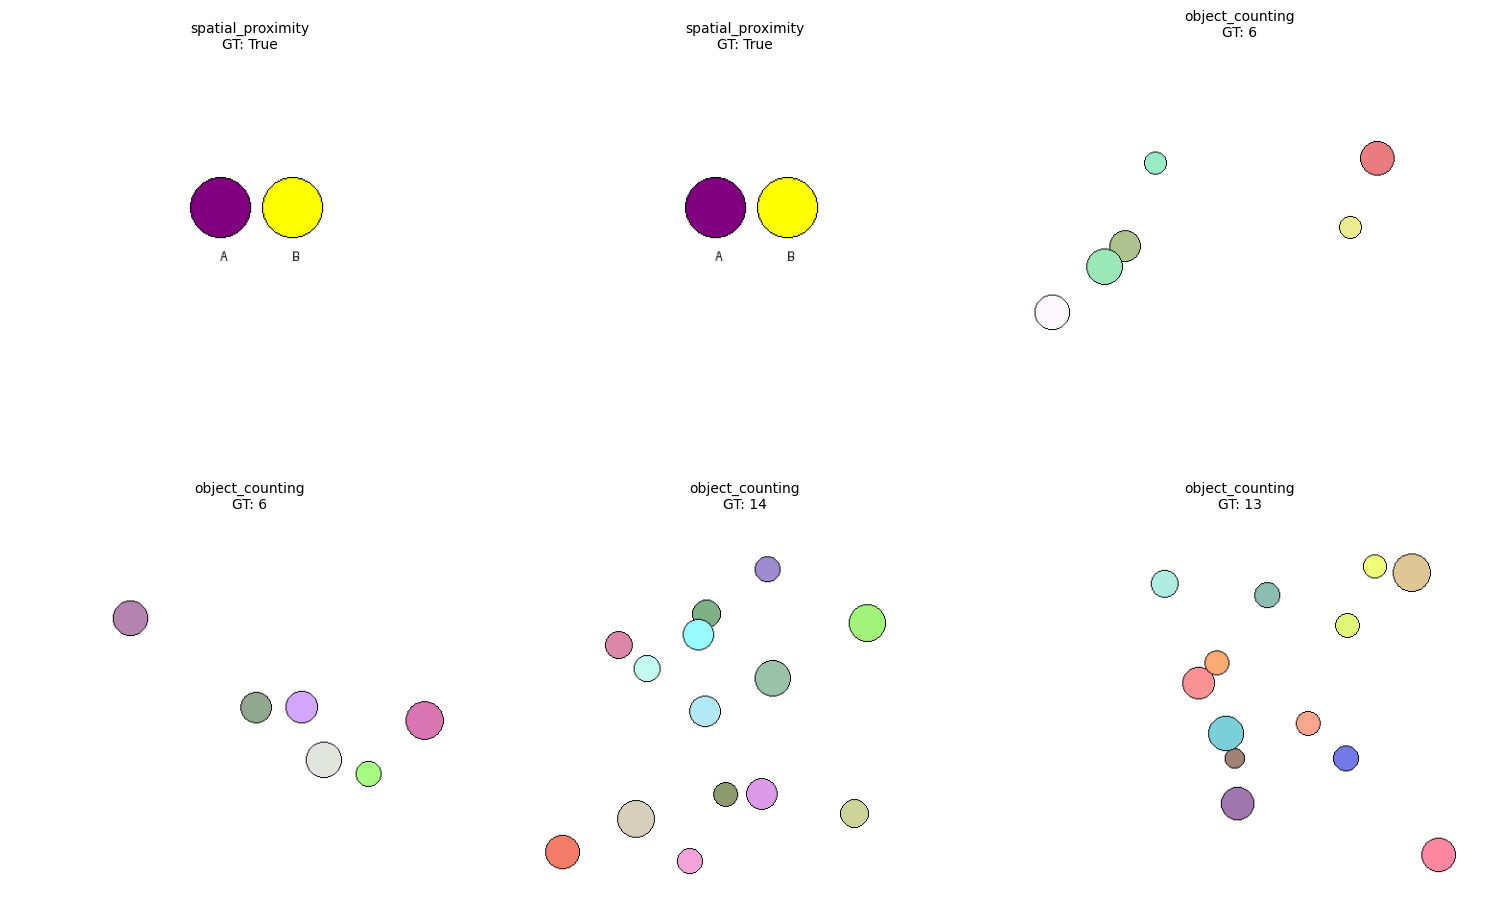

Sample prompts:

spatial_prox_11: Are object A and object B close to each other? Answer with only 'yes' or 'no'.

spatial_prox_6: Are object A and object B close to each other? Answer with only 'yes' or 'no'.

counting_0: Count the number of circles in the image. Provide only the number.


In [16]:
# Visualize Sample Tasks
def visualize_sample_tasks(tasks: List[VisualReasoningTask], num_samples: int = 6):
    """Visualize sample tasks from the dataset"""

    sample_tasks = np.random.choice(tasks, min(num_samples, len(tasks)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, task in enumerate(sample_tasks):
        img = Image.open(task.image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')

        title = f"{task.task_type}\nGT: {task.ground_truth}"
        axes[idx].set_title(title, fontsize=10)

    plt.tight_layout()
    plt.savefig("sample_tasks.png", dpi=150, bbox_inches='tight')
    plt.show()

    print("Sample prompts:")
    for task in sample_tasks[:3]:
        print(f"\n{task.task_id}: {task.prompt}")

visualize_sample_tasks(all_tasks)

In [17]:
# Evaluation Metrics
class EvaluationMetrics:
    """Calculate evaluation metrics for visual reasoning tasks"""

    @staticmethod
    def parse_spatial_response(response: str) -> Optional[bool]:
        """Parse yes/no response for spatial tasks"""
        response_lower = response.lower().strip()

        if 'yes' in response_lower:
            return True
        elif 'no' in response_lower:
            return False
        else:
            return None

    @staticmethod
    def parse_counting_response(response: str) -> Optional[int]:
        """Parse numeric response for counting tasks"""
        import re

        # Find all numbers in response
        numbers = re.findall(r'\d+', response)

        if numbers:
            return int(numbers[0])
        else:
            return None

    @staticmethod
    def calculate_metrics(results: List[EvaluationResult]) -> Dict:
        """Calculate precision, recall, F1, and other metrics"""

        # Separate spatial and counting results
        spatial_results = [r for r in results if isinstance(r.ground_truth, bool)]
        counting_results = [r for r in results if isinstance(r.ground_truth, int)]

        metrics = {}

        # Overall metrics for spatial tasks (binary classification)
        if spatial_results:
            y_true = [int(r.ground_truth) for r in spatial_results]
            y_pred = [int(r.predicted) if r.predicted is not None else 0
                     for r in spatial_results]

            # Calculate confusion matrix components
            tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
            fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
            fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))
            tn = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            metrics['spatial'] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': sum(r.correct for r in spatial_results) / len(spatial_results),
                'true_positives': tp,
                'false_positives': fp,
                'false_negatives': fn,
                'true_negatives': tn,
                'total_samples': len(spatial_results)
            }

        # Metrics for counting tasks
        if counting_results:
            errors = [abs(r.predicted - r.ground_truth) if r.predicted is not None else r.ground_truth
                     for r in counting_results]

            mae = np.mean(errors)
            accuracy = sum(r.correct for r in counting_results) / len(counting_results)

            metrics['counting'] = {
                'mae': mae,
                'accuracy': accuracy,
                'total_samples': len(counting_results)
            }

        # Overall metrics
        all_correct = [r.correct for r in results]

        # For overall F1, treat all as binary (correct/incorrect)
        y_true_all = [1] * len(results)
        y_pred_all = [1 if r.correct else 0 for r in results]

        tp_all = sum(y_pred_all)
        fp_all = 0
        fn_all = len(results) - tp_all

        precision_all = tp_all / (tp_all + fp_all) if (tp_all + fp_all) > 0 else 0
        recall_all = tp_all / (tp_all + fn_all) if (tp_all + fn_all) > 0 else 0
        f1_all = 2 * (precision_all * recall_all) / (precision_all + recall_all) if (precision_all + recall_all) > 0 else 0

        metrics['overall'] = {
            'precision': precision_all,
            'recall': recall_all,
            'f1_score': f1_all,
            'accuracy': np.mean(all_correct),
            'true_positives': tp_all,
            'false_negatives': fn_all,
            'total_samples': len(results)
        }

        return metrics

print("✓ Evaluation metrics defined")

✓ Evaluation metrics defined


In [18]:

# Create mock results for testing
def create_mock_results() -> List[EvaluationResult]:
    """Create mock evaluation results for testing"""

    mock_results = []

    # Mock spatial results
    for i in range(40):
        gt = bool(np.random.choice([True, False]))
        # Simulate 70% accuracy
        pred = gt if np.random.random() > 0.3 else not gt

        mock_results.append(EvaluationResult(
            task_id=f"spatial_{i}",
            predicted=pred,
            ground_truth=gt,
            correct=(pred == gt),
            response_text="yes" if pred else "no",
            tokens_used=50
        ))

    # Mock counting results
    for i in range(35):
        gt = np.random.randint(5, 21)
        # Simulate counting with some error
        error = np.random.randint(-2, 3)
        pred = max(0, gt + error)

        mock_results.append(EvaluationResult(
            task_id=f"counting_{i}",
            predicted=pred,
            ground_truth=gt,
            correct=(pred == gt),
            response_text=str(pred),
            tokens_used=50
        ))

    return mock_results

# Test metrics calculation
print("Testing evaluation metrics with mock data...")
mock_results = create_mock_results()
test_metrics = EvaluationMetrics.calculate_metrics(mock_results)

print("\nMock Results:")
print(json.dumps(test_metrics, indent=2))

print("\nEvaluation pipeline tested successfully")

Testing evaluation metrics with mock data...

Mock Results:
{
  "spatial": {
    "precision": 0.8,
    "recall": 0.6153846153846154,
    "f1_score": 0.6956521739130435,
    "accuracy": 0.65,
    "true_positives": 16,
    "false_positives": 4,
    "false_negatives": 10,
    "true_negatives": 10,
    "total_samples": 40
  },
  "counting": {
    "mae": 0.7066666666666667,
    "accuracy": 0.4666666666666667,
    "total_samples": 75
  },
  "overall": {
    "precision": 1.0,
    "recall": 0.4666666666666667,
    "f1_score": 0.6363636363636364,
    "accuracy": 0.4666666666666667,
    "true_positives": 35,
    "false_negatives": 40,
    "total_samples": 75
  }
}

Evaluation pipeline tested successfully


In [19]:
# Dataset Statistics
def print_dataset_statistics(tasks: List[VisualReasoningTask]):
    """Print statistics about the dataset"""

    task_types = {}
    for task in tasks:
        task_type = task.task_type
        if task_type not in task_types:
            task_types[task_type] = 0
        task_types[task_type] += 1

    print("\n" + "="*60)
    print("DATASET STATISTICS")
    print("="*60)
    print(f"\nTotal Tasks: {len(tasks)}")
    print(f"\nTask Distribution:")
    for task_type, count in task_types.items():
        percentage = (count / len(tasks)) * 100
        print(f"  {task_type}: {count} ({percentage:.1f}%)")

    # Spatial task breakdown
    spatial_tasks = [t for t in tasks if 'spatial' in t.task_type]
    if spatial_tasks:
        print(f"\nSpatial Tasks: {len(spatial_tasks)}")
        true_count = sum(1 for t in spatial_tasks if t.ground_truth == True)
        false_count = len(spatial_tasks) - true_count
        print(f"  Positive (True): {true_count}")
        print(f"  Negative (False): {false_count}")

    # Counting task breakdown
    counting_tasks = [t for t in tasks if 'counting' in t.task_type]
    if counting_tasks:
        counts = [t.ground_truth for t in counting_tasks]
        print(f"\nCounting Tasks: {len(counting_tasks)}")
        print(f"  Min objects: {min(counts)}")
        print(f"  Max objects: {max(counts)}")
        print(f"  Mean objects: {np.mean(counts):.2f}")
        print(f"  Median objects: {np.median(counts):.0f}")

    print("\n" + "="*60)

print_dataset_statistics(all_tasks)


DATASET STATISTICS

Total Tasks: 75

Task Distribution:
  spatial_left_right: 13 (17.3%)
  spatial_above_below: 13 (17.3%)
  spatial_proximity: 14 (18.7%)
  object_counting: 35 (46.7%)

Spatial Tasks: 40
  Positive (True): 26
  Negative (False): 14

Counting Tasks: 35
  Min objects: 5
  Max objects: 20
  Mean objects: 12.46
  Median objects: 12



In [20]:
import pickle
import json
import numpy as np
from pathlib import Path

# Save tasks as pickle for easy loading
tasks_pickle_path = Path("all_tasks.pkl")
with open(tasks_pickle_path, 'wb') as f:
    pickle.dump(all_tasks, f)

print(f"Tasks saved to {tasks_pickle_path}")

# ---- Helper function for JSON-safe serialization ----
def convert_to_serializable(obj):
    """Recursively convert NumPy and non-serializable types to native Python types."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, Path):
        return str(obj)
    else:
        return obj

# Convert tasks to JSON-safe structure
json_safe_tasks = convert_to_serializable([task.to_dict() for task in all_tasks])

# Save as JSON for readability
tasks_json_path = Path("all_tasks.json")
with open(tasks_json_path, 'w') as f:
    json.dump(json_safe_tasks, f, indent=2)

print(f"Tasks saved to {tasks_json_path}")


Tasks saved to all_tasks.pkl
Tasks saved to all_tasks.json
